# MSEPM Model Simulations
- Workflow for simulating factor associated methylation matrices, fitting MSEPM models, and assessing the fit models against the simulated values

## Notebook Setup

In [1]:
import bisect
from collections import defaultdict, Counter
import copy
import math
import pkg_resources
from itertools import combinations, cycle
import os
import random
import sys
from typing import Dict, List, Set, Tuple, Union

from methsim.celltype import get_ct_meth_matrix, set_blood_ct_comp, get_blood_ct_estimates_by_age
from methsim.phenotype import binary_normal, continuous_normal, single_exp_assoc, continuous_exponential
from methsim.sample import gen_pheno_matrix, simulate_samples
from methsim.site import GenerateSampleMethylation
from methsim.utilities import gen_depth_adj_estimates

from msepm import MultistateEpigeneticPacemaker, MultistateEpigeneticPacemakerCV
from msepm.helpers import pearson_correlation
from msepm.scaler import Scaler

from IPython.display import display, Markdown, Latex, HTML
import joblib
import matplotlib as mpl
from matplotlib import cm, rc
from matplotlib.colors import LogNorm, Normalize, NoNorm
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import pickle
from scipy import optimize
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf    
from tqdm import tqdm

In [2]:
wd = os.path.abspath(os.path.join(os.getcwd(), '..'))

In [3]:
def get_session_info(import_diff_modules=[]):
    '''
    Retrieve python version and list of imported packages that 
    are imported directly or as dependencies:
        Args:
            import_diff_modules (List[str]): list of modules that have different install and 
                                        import names, ie scikit-learn imported with sklearn
        Returns:
            Dict[str, str]: package_name : version 
    '''
    local_pkgs = {str(i).split()[0]:str(i).split()[1] for i in pkg_resources.working_set}
    session_pkgs = {'Python':sys.version}
    for pkg in sorted(list(set([x.split('.')[0] for x in sys.modules])) + import_diff_modules):
        if pkg in local_pkgs:
            session_pkgs[pkg] = local_pkgs[pkg]
    return session_pkgs

In [4]:
# collect session info
session_info = get_session_info(import_diff_modules=['scikit-learn'])

In [5]:
display(HTML(pd.DataFrame(session_info, index=['Package', 'Version']).T.to_html()))

,Package,Version
Python,"3.10.4 (main, May 3 2022, 09:55:33) [GCC 11.2.0]","3.10.4 (main, May 3 2022, 09:55:33) [GCC 11.2.0]"
asttokens,2.0.5,2.0.5
backcall,0.2.0,0.2.0
cffi,1.17.1,1.17.1
comm,0.2.2,0.2.2
cycler,0.11.0,0.11.0
debugpy,1.6.0,1.6.0
decorator,5.1.1,5.1.1
defusedxml,0.7.1,0.7.1
executing,0.8.3,0.8.3


### Set Plot Characteristics

In [6]:
sns.set(palette="Paired", style='white')
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['text.usetex'] = True

In [7]:
rng = np.random.default_rng()

# Set Simulation Phenotypes

### Set phenotype time associations
- $Age, p^0 \sim \mathcal{U}(0,100)$ 
- $Sex, p^0 \sim B(1, 0.5)$
- $CN, p^0 \sim \mathcal{N}(1, .1)$ 
- $CE, p^0 \sim \\frac{1}{20}e^{-x/20}$

In [8]:
sqrt_age_assoc = single_exp_assoc(age_weight=1.0, age_exponent=0.5)
linear_age_assoc = single_exp_assoc(age_weight=1.0, age_exponent=1.0)
no_age_assoc = single_exp_assoc(age_weight=1.0, age_exponent=0.0)

### Define Sim Generators

In [9]:
def gen_phenotypes(std_dist = .01):
    phenotype = {}
    labels = ['continuous_sqrt_age', 'continuous_lin_age', 
              'continuous_no_age', 'continuous_no_age_exp',
              'binary_only', 'binary_sqrt_age']
    phenotype[labels.pop(0)] = continuous_normal(mean=1.0, std=0.0001, time_association=sqrt_age_assoc)
    phenotype[labels.pop(0)] = continuous_normal(mean=1.0, std=0.0001, time_association=linear_age_assoc)
    phenotype[labels.pop(0)] = continuous_normal(mean=1.0, std=std_dist, time_association=no_age_assoc)
    phenotype[labels.pop(0)] = continuous_exponential(scale=20.0, time_association=no_age_assoc)
    phenotype[labels.pop(0)] = binary_normal(.001, std=0.0, time_association=no_age_assoc)
    phenotype[labels.pop(0)] = binary_normal(.001, std=0.001, time_association=sqrt_age_assoc)
    return phenotype

In [10]:
def gen_samples(min_age=0, max_age=100, health_variation=0.1, phenotypes=None, sample_count=1000):
    samples = simulate_samples(min_age=min_age, max_age=max_age, sample_count=sample_count,
                               health_variation=health_variation, phenotypes=phenotypes)
    return samples

In [11]:
def gen_meth_matrices(meth_generator, samples, conditions, scale_min=None, scale_max=None):
    meth_matrix, meth_error = meth_generator.generate_sample_methylation(samples, sim_conditions=conditions, 
                                                                         scale_min=scale_min, scale_max=scale_max)
    return meth_matrix, meth_error

### Define Run Generators
1. Vary the number input phenotypes
2. Vary the methylation matrix composition 
3. Vary cell type composition contribution 
4. Vary the read depth 

In [12]:
def gen_simulation_data(std_dist, sample_kwargs, conditions, meth_generator):
    pheno = gen_phenotypes(std_dist)
    samples = gen_samples(phenotypes=pheno, **sample_kwargs)
    meth_matrix, meth_error = meth_generator.generate_sample_methylation(samples, conditions)
    return pheno, samples, meth_matrix, meth_error

In [13]:
def run_msepm(train_x, train_y, test_y, label):
    msepm = MultistateEpigeneticPacemaker(verbose=False, n_jobs=1, 
                                          learning_rate=0.01, iter_limit=200)
    msepm.fit(train_x, train_y)
    test_states, test_meth_values = msepm.predict(test_y, return_site_predictions=True)
    return test_states, test_meth_values, msepm, test_y, label

In [14]:
def run_simulations(runs, n_jobs=8, verbose=0):
    models = joblib.Parallel(n_jobs=n_jobs, verbose=verbose)(joblib.delayed(run_msepm)(*run) for run in runs)
    models = {model[4]: dict(states=model[0], test_predicted_meth=model[1], msepm=model[2], test_meth_values=model[3]) for model in models}
    return models

### Vary the Number of Simulation Phenotypes

In [15]:
def fit_varried_inputs(fit_phenotypes: List[str], phenotype_std_dist=0.1, 
                       sample_kwargs = None, site_conditions=None, meth_generator=None,
                       train_proportion=.5,
                       verbose=0, n_jobs=8, q_scaler=None, p_scaler=None):
    # generate phenotype info 
    pheno = gen_phenotypes(phenotype_std_dist)
    samples = gen_samples(phenotypes=pheno, **sample_kwargs)
    
    meth_matrix, meth_error = gen_meth_matrices(meth_generator, samples, site_conditions, 
                                                np.array([0.0, 0.001, 0.545, 0.]), 
                                                np.array([10.0, 1.0, 1.455, 215]))
    
    # set train and test sets 
    train_indices = np.random.choice([x for x in range(len(samples))], size=int(len(samples) * train_proportion), 
                                     replace=False)
    test_indices = np.array([x for x in range(len(samples)) if x not in train_indices])
    
    # set methylation matrices 
    train_y = meth_matrix[:, train_indices]
    test_y = meth_matrix[:, test_indices]
    
    q_matrix = gen_pheno_matrix(samples, fit_phenotypes, key='exposure')
    p_matrix = gen_pheno_matrix(samples, fit_phenotypes, key='value')
    
    scaled_q = q_scaler.transform(q_matrix)
    scaled_p = p_scaler.transform(p_matrix)
    # retrieve and scale phenotypes 
    runs = []
    models = {}
    for phenos in range(len(fit_phenotypes)):
        phenotypes = fit_phenotypes[:phenos+1]
        run_label = ','.join(phenotypes)
        models[run_label] = {'test_phenotypes':scaled_p[test_indices,:phenos+1], 'phenotype':phenotypes,
                             'test_exposures':scaled_q[test_indices,:phenos+1]}
        runs.append([scaled_q[train_indices,:phenos+1], meth_matrix[:,train_indices], 
                     meth_matrix[:,test_indices], run_label])
    
    model_runs = run_simulations(runs, n_jobs=n_jobs, verbose=verbose)
    for label, results in model_runs.items():
        models[label].update(results)
    return models

In [16]:
def assess_varried_pheno_model(model):
    trans_phenos = model['test_phenotypes']
    r2 = pearson_correlation(trans_phenos, model['states'].T)
    r2 = [r2[x][x]**2 for x in range(r2.shape[0])]
    mae = np.mean(abs(trans_phenos - model['states']), axis=0)
    coefs = model['msepm']._coefs
    error = model['msepm']._error
    site_error = np.mean(abs(model['test_predicted_meth'] - model['test_meth_values']), axis=1)
    return dict(r2=r2, mae=mae, coefs=coefs, model_error=error, mean_site_error=site_error,
                phenotypes=model['phenotype'], pheno_len=len(model['phenotype']),
                test_predicted_meth=model['test_predicted_meth'], test_actual_meth=model['test_meth_values'])

In [17]:
fit_phenos = ['age', 'binary_only', 'continuous_no_age',  'continuous_no_age_exp']

In [18]:
condition_phenos = ['continuous_sqrt_age', 'binary_only', 'continuous_no_age',  'continuous_no_age_exp']

In [19]:
phenotype_combinations = [fit_phenos[:x + 1] for x in range(len(fit_phenos))]

In [20]:
site_condition_count = 10

In [21]:
condition_weights = [np.array([1.0, 0.0, 0.0, 0.0]), 
                     np.array([0.0, 1.0, 0.0, 0.0]),
                     np.array([0.0, 0.0, 1.0, 0.0]),
                     np.array([0.0, 0.0, 0.0, 1.0]),
                     np.array([0.0, 0.0, 0.0, 0.0])]
                     
                     
for _ in range(site_condition_count):
    weights = np.zeros(4)
    weights[0:2] = rng.uniform(-.1, 1, 2)
    condition_weights.append(weights)
    
for _ in range(site_condition_count):
    weights = np.zeros(4)
    weights[1:3] = rng.uniform(-.1, 1, 2)
    condition_weights.append(weights)
    
for _ in range(site_condition_count):
    weights = np.zeros(4)
    weights[2:4] = rng.uniform(-.1, 1, 2)
    condition_weights.append(weights)
    
for _ in range(site_condition_count):
    condition_weights.append(rng.uniform(-0.2,1,4))

In [22]:
single_site_types = ['Age', 'Sex', 
                     'CN', 'CE']
mixed_site_types = ['Noise', 'Age, Sex', 'Sex, CN', 
                    'CN ,CE', 'Age, Sex,\n CN, CE']

In [23]:
conditions = [[condition_phenos, 10 , weights] for weights in condition_weights[:5]]
conditions.extend([[condition_phenos, 1, weights] for weights in condition_weights[5:]])

In [24]:
meth_generation_kwargs = dict(deviation_low=0.025, deviation_high=.05,
                              delta_low=0.2, delta_high=0.7, number_of_sites=1000)

In [25]:
## initialize meth generator 
meth_gen = GenerateSampleMethylation()
meth_gen.generate_methylation_sites(**meth_generation_kwargs)

In [26]:
# set sample coefs with large sim set
phenotype_std_dist = 0.1

sim_samples = gen_samples(phenotypes=gen_phenotypes(std_dist=phenotype_std_dist), sample_count=50000)

In [27]:
scale_min = np.min(gen_pheno_matrix(sim_samples, fit_phenos, key='exposure'),axis=0)
scale_min[0] = 0.0
scale_min[3] = 0.0
scale_max = np.max(gen_pheno_matrix(sim_samples, fit_phenos, key='exposure'),axis=0)

In [28]:
p_scale_min = np.min(gen_pheno_matrix(sim_samples, fit_phenos, key='value'),axis=0)
p_scale_min[0] = 0.0
p_scale_min[3] = 0.0
p_scale_max = np.max(gen_pheno_matrix(sim_samples, fit_phenos, key='value'),axis=0)

In [29]:
q_scaler = Scaler(X_min=np.zeros((1, 4)).astype(float),
                  X_max=np.ones((1, 4)).astype(float))
q_scaler.X_min = scale_min
q_scaler.X_max = scale_max

p_scaler = Scaler(X_min=np.zeros((1, 4)).astype(float),
                  X_max=np.ones((1, 4)).astype(float))
p_scaler.X_min = p_scale_min
p_scaler.X_max = p_scale_max

In [30]:
_, _  = meth_gen.generate_sample_methylation(sim_samples, sim_conditions=conditions) 

In [31]:
# output site characteristics 
simulated_site_info = []

for site, info in meth_gen.sim_site_order.items():
    _site_info = list(meth_gen.methylation_sites[site])
    _site_info.append(_site_info[1] - _site_info[0])
    _site_info.extend(list(info[2]))
    simulated_site_info.append(_site_info)

site_df = pd.DataFrame(simulated_site_info, index=None, 
                       columns=['Inital Meth. Value (r^0)', 'Target meth. value', 
                                'Site STD', 'Site Delta',
                                'Age r', 'Sex r', 'CN r', 'CE r'])
site_df.to_csv(os.path.join(wd, 'Paper/SupplementalTables/SupplementalTable4.tsv'), sep='\t', float_format='%.3f', index=False)

In [32]:
r_0_cmap = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=1), 
                             cmap='bone_r')
delta_cmap = cm.ScalarMappable(norm=Normalize(vmin=0, vmax=1), 
                             cmap='PRGn')

In [33]:
color_scaler = Scaler(X_min=0, X_max=1)
color_scaler.X_min = -1
color_scaler.X_max = 1

In [34]:
r_0_colors = r_0_cmap.cmap(site_df['Inital Meth. Value (r^0)'].values)

delta_colors = delta_cmap.cmap(color_scaler.transform(site_df['Site Delta'].values)) 

In [35]:
sampling_pheno = gen_pheno_matrix(sim_samples, fit_phenos, key='exposure')
meth_pheno = gen_pheno_matrix(sim_samples, condition_phenos, key='value')

### Plot Traits and Methylation Association

/tmp/ipykernel_37381/1110479773.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([-1.0, 0.0, 1.0])


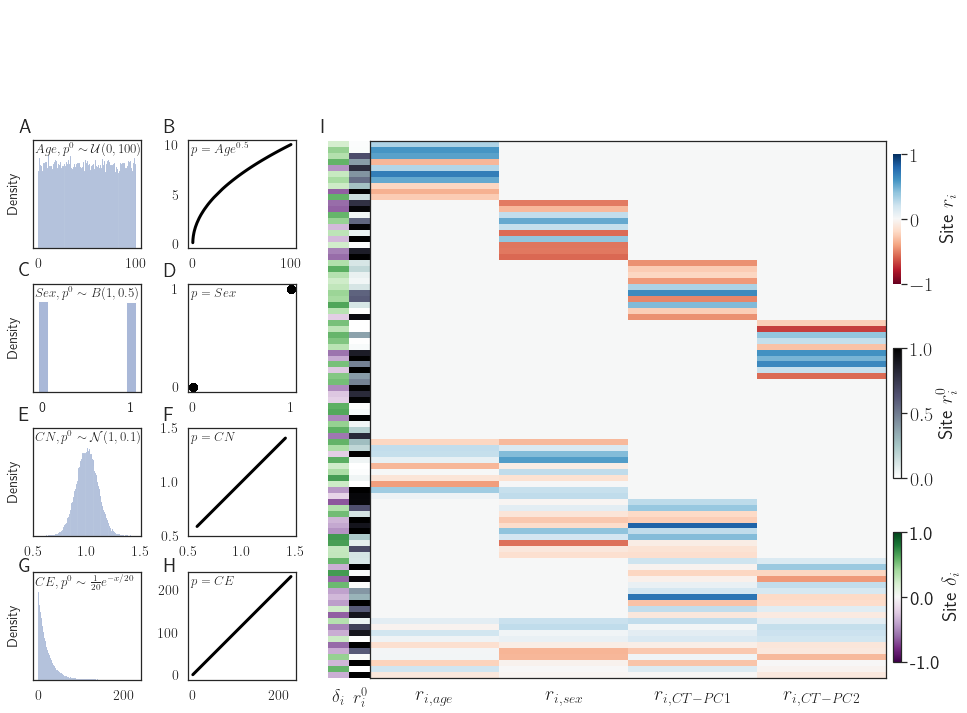

In [36]:
plot = sns.clustermap(site_df[['Age r','Sex r','CN r','CE r']], figsize=(10,10), 
                      cmap='RdBu', yticklabels=False, vmin=-1, vmax=1, tree_kws=dict(linewidth=1),
                      cbar_kws=dict(label='Site $r_i$'), row_colors = [delta_colors, r_0_colors],
                      row_cluster=False, col_cluster=False, cbar_pos=(.995, 0.6, 0.01, 0.18)) 

cbaxes = plot.fig.add_axes([.995, 0.33, 0.01, 0.18])  
cbar = plot.fig.colorbar(r_0_cmap, cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel(f'Site $r^0_i$', fontsize=20)
plot.ax_heatmap.text(0.245, 0.02, '$r^0_i$', 
                     fontsize=18, transform=plt.gcf().transFigure)

cbaxes = plot.fig.add_axes([.995, 0.075, 0.01, 0.18])  
cbar = plot.fig.colorbar(delta_cmap, cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel(f'Site $\delta_i$', fontsize=20)
cbar.ax.set_yticklabels([-1.0, 0.0, 1.0])
plot.ax_heatmap.text(0.215, 0.02, '$\delta_i$', 
                     fontsize=18, transform=plt.gcf().transFigure)

plot.ax_heatmap.set(xticklabels=['$r_{i,age}$','$r_{i,sex}$',
                                 '$r_{i, CT-PC1}$','$r_{i, CT-PC2}$'])


for _, spine in plot.ax_heatmap.spines.items():
    spine.set_visible(True)
    
pheno_dist = ['$Age, p^0 \sim \mathcal{U}(0,100)$', '$Sex, p^0 \sim B(1, 0.5)$', 
              f'$CN, p^0 \sim \mathcal{{N}}(1, {phenotype_std_dist})$', 
              '$CE, p^0 \sim \\frac{1}{20}e^{-x/20}$']
meth_assoc = ['$p = Age^{0.5}$', '$p = Sex$', '$p = CN$', '$p = CE$']

subplot_size = .15

fit_pos = [.65, .45, .25, 0.05]

for count, pheno in enumerate(fit_phenos):
    ax1 = plot.fig.add_axes([-.2, fit_pos[count], subplot_size, subplot_size])
    ax2 = plot.fig.add_axes([0.015, fit_pos[count], subplot_size, subplot_size])

    ax1.text(.02,.88,pheno_dist[count], fontsize=13, transform=ax1.transAxes)
    ax2.text(.02,.88,meth_assoc[count], fontsize=13, transform=ax2.transAxes) 
    ax1.set_yticklabels('')
    ax1.set_ylabel('Density', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)

    if count != 1:
        sns.histplot(sampling_pheno[:,count], ax=ax1, kde=False, bins=100, 
                     stat='density', color=np.array([sns.color_palette("Set2")[2]]))
        #sns.kdeplot(sampling_pheno[:,count], ax=ax[0, count],
        #            color='k', cut=0, lw=3)
        ax2.plot(sorted(sampling_pheno[:,count]), sorted(meth_pheno[:,count]), 'k-', lw=3)
        if count == 0:
            ax1.set_ylim(0,0.013)
        if count == 2:
            ax1.set_ylim(0,5)
            ax1.set_xticks([0.5, 1.0, 1.5])
            ax2.set_xticks([0.5, 1.0, 1.5])
            ax2.set_yticks([0.5, 1.0, 1.5])
        if count == 3:
            ax1.set_ylim(0,0.06)
    else:
        sns.histplot(sampling_pheno[:,count], ax=ax1, kde=False, bins=10, 
                     stat='density', color=np.array([sns.color_palette("Set2")[2]]))
        ax1.set_xticks([0.05, .95])
        ax1.set_xticklabels([0,1])
        ax2.set_xticks([0, 1])
        ax2.set_yticks([0, 1])
        ax1.set_ylim(0,6)
        #sns.kdeplot(sampling_pheno[:,count], ax=ax[0, count],
        #            color='k', cut=0, lw=3, bw_adjust=.2)
        ax2.scatter(sorted(sampling_pheno[:,count]), sorted(meth_pheno[:,count]), color='k', s=50)
        
ax1.text(-.22, .81, 'A', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(-.018, .81, 'B', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(-.22, .61, 'C', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(-.018, .61, 'D', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(-.22, .41, 'E', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(-.018, .41, 'F', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(-.22, .2, 'G', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(-.018, .2, 'H', fontsize=20, transform=plt.gcf().transFigure, weight='bold')
ax1.text(0.2, .81, 'I', fontsize=20, transform=plt.gcf().transFigure, weight='bold')

plt.savefig(os.path.join(wd,'Paper/Figures/Figure1.png'), dpi=200, bbox_inches='tight')
plt.show()

In [37]:
sample_kwargs = dict(min_age=0, max_age=100, sample_count=1000)

In [38]:
results = {}

sim_iterations = 1000

sim_states = defaultdict(list)
sim_exposures = defaultdict(list)

for run in tqdm(range(sim_iterations)):
    iter_models = fit_varried_inputs(['age', 'binary_only', 'continuous_no_age', 'continuous_no_age_exp'], phenotype_std_dist=phenotype_std_dist,
                                      sample_kwargs=sample_kwargs, site_conditions=conditions,
                                      meth_generator=meth_gen, n_jobs=24,
                                      train_proportion=.5, q_scaler=q_scaler, p_scaler=p_scaler)
    for model_label, model in iter_models.items():
        sim_states[model_label].append(np.array(model['states']))
        sim_exposures[model_label].append(np.array(model['test_exposures']))
    results[run] = {label: assess_varried_pheno_model(model) for label, model in iter_models.items()}
    for label in results[run]:
        results[run][label]['msepm'] = iter_models[label]['msepm']

100%|█████████████████████████████████████████████████| 1000/1000 [12:17<00:00,  1.36it/s]


## Site Model Information

#### Simulation site categorization

In [39]:
site_types = single_site_types + mixed_site_types

In [40]:
site_colors = []
color_key = {}
cmap = plt.cm.get_cmap('tab20b', len(site_types))
site_deviation = []
mixed_sites = []
site_labels = []

observed_types = set()

for count, site in enumerate(meth_gen.sim_site_order.values()):
    site_label = ','.join([single_site_types[x] for x, y in enumerate(site[2]) if y])
    if site_label not in observed_types:
        observed_types.add(site_label)
    site_labels.append(site_types[len(observed_types) -1 ])
    site_info = meth_gen.methylation_sites[site[0]]
    site_deviation.append(abs(site_info[0] - site_info[1]))
    if site_label not in color_key:
        color_key[site_label] = cmap(len(color_key))
    site_colors.append(color_key[site_label])

/tmp/ipykernel_37381/1254343864.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(site_types))


In [41]:
site_deviation = np.array(site_deviation).reshape(-1,1)

In [42]:
model_of_interest = 'age,binary_only,continuous_no_age,continuous_no_age_exp'

In [43]:
average_coefs = np.zeros(iter_models[model_of_interest]['msepm']._coefs.shape)

for count, model in enumerate(results.values()):
    average_coefs += model[model_of_interest]['msepm']._coefs
    
average_coefs = average_coefs / (count + 1) / site_deviation

In [44]:
coef_df = pd.DataFrame(average_coefs, 
                       columns=['Age r_i', 'Sex r_i', 'CN r_i', 'CE r_i'])

### MSEPM Fit Ceofficient vs Simulated Site Coefficient

In [45]:
sim_coefs = np.array([x[-1] for x in meth_gen.sim_site_order.values()])

In [46]:
sim_intercepts = np.array([meth_gen.methylation_sites[x[0]][0] for x in meth_gen.sim_site_order.values()])

In [47]:
iter_coefs = []
model_corrs = []
iter_intercepts = []

for _iter, models in results.items():
    
    model = models[model_of_interest]
    model_info = np.zeros((model['msepm']._coefs.shape[0], 
                           model['msepm']._coefs.shape[1]*2))
    model_info[:, 0:model['msepm']._coefs.shape[1]] = model['msepm']._coefs
    model_info[:, model['msepm']._coefs.shape[1]:] = sim_coefs
    model_corrs.append(stats.pearsonr(model_info[:,:model['msepm']._coefs.shape[1]].flatten(), 
                                      model_info[:,model['msepm']._coefs.shape[1]:].flatten()))
    iter_coefs.append(model_info)
    
    _iter_inter = np.zeros((model['msepm']._intercepts.shape[0], 2))
    _iter_inter[:,0] = model['msepm']._intercepts
    _iter_inter[:,1] = sim_intercepts
    iter_intercepts.append(_iter_inter)

In [48]:
model_r2 = [x[0]**2 for x in model_corrs]
np.mean(model_r2), np.std(model_r2)

(0.9448490879282979, 0.022848461266649894)

In [49]:
_site_coefs = np.concatenate(iter_coefs, axis=0)
_site_inters = np.concatenate(iter_intercepts, axis=0)

In [50]:
_site_inters.shape, _site_coefs.shape

((90000, 2), (90000, 8))

In [51]:
sim_coefs, fit_coefs, sim_phenos = [], [], []

for count, pheno in enumerate(single_site_types):
    fit_coefs.extend(list(_site_coefs[:,count].astype(np.float64).flatten()))
    sim_coefs.extend(list(_site_coefs[:,count+4].astype(np.float64).flatten()))
    sim_phenos.extend([pheno for _ in range(_site_coefs.shape[0])])

In [52]:
stats.pearsonr(_site_inters[:,0], _site_inters[:,1])[0]**2, stats.pearsonr(sim_coefs, fit_coefs)[0]**2

(0.9829631663363515, 0.9397070245693191)

In [53]:
site_coef_df = pd.DataFrame(np.array([sim_coefs, fit_coefs, sim_phenos]), 
                            index=['Simulated Coefficient', 'Fit Coefficient', 'Sim. Factor']).T
site_coef_df = site_coef_df.apply(pd.to_numeric, errors='ignore')

In [54]:
site_inter_df = pd.DataFrame(_site_inters, columns=['Simulated $r^0_i$', 'Fit $r^0_i$'])

In [55]:
def sqrt_func(x, a, b, c):
    return a * np.asarray(x)**0.5 + c

In [56]:
def lin_func(x, a, b, c):
    return a * np.asarray(x) + c

## Evaluate Model Performance

In [57]:
meth_values = {}

for model in results.values():
    for mod, res in models.items():
        if mod not in meth_values:
            meth_values[mod] = {'predicted':[res['test_predicted_meth'].flatten()], 
                                'actual':[res['test_actual_meth'].flatten()]}
        else:
            meth_values[mod]['predicted'].append(res['test_predicted_meth'].flatten())
            meth_values[mod]['actual'].append(res['test_actual_meth'].flatten())
            
for mod in list(meth_values.keys()):
    meth_values[mod]['predicted'] = np.array(meth_values[mod]['predicted']).flatten()
    meth_values[mod]['actual'] = np.array(meth_values[mod]['actual']).flatten()

In [58]:
merged_results = {','.join(x):defaultdict(list) for x in phenotype_combinations}

for models in results.values():
    for mod, res in models.items():
        for cat in ['r2', 'mae', 'coefs', 'mean_site_error']:
            merged_results[mod][cat].append(res[cat])

In [59]:
plot_info = []

fit_phenos = ['Age', 'Binary', 'Continuous Normal', 'Contiuous Expoenetial']

for cat, res in merged_results.items():
    for x, y, z in zip(res['mae'], res['r2'], res['mean_site_error']):
        for count in range(len(cat.split(','))):
            plot_info.append([len(cat.split(',')), x[count], y[count], fit_phenos[count]]) 
        
plot_df = pd.DataFrame(plot_info, columns=['Factor Count', 'Factor MAE', '$R^2$', 'Factor'])

In [60]:
site_error_plot = []

for cat, res in merged_results.items():
    for exp, site_mae in enumerate(res['mean_site_error']):
        for count, site in enumerate(site_mae):  
            site_error_plot.append([len(cat.split(',')), site, site_labels[count]])

site_error_df = pd.DataFrame(site_error_plot, columns=['Factor', 'Site MAE', 'Site Associated Factor(s)'])

/tmp/ipykernel_37381/1385458409.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Age', 'Age, Sex', 'Age, Sex, CN', 'Age, Sex, CN, CE'])
/tmp/ipykernel_37381/1385458409.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Age', 'Age, Sex', 'Age, Sex, CN', 'Age, Sex,\nCN, CE'])
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


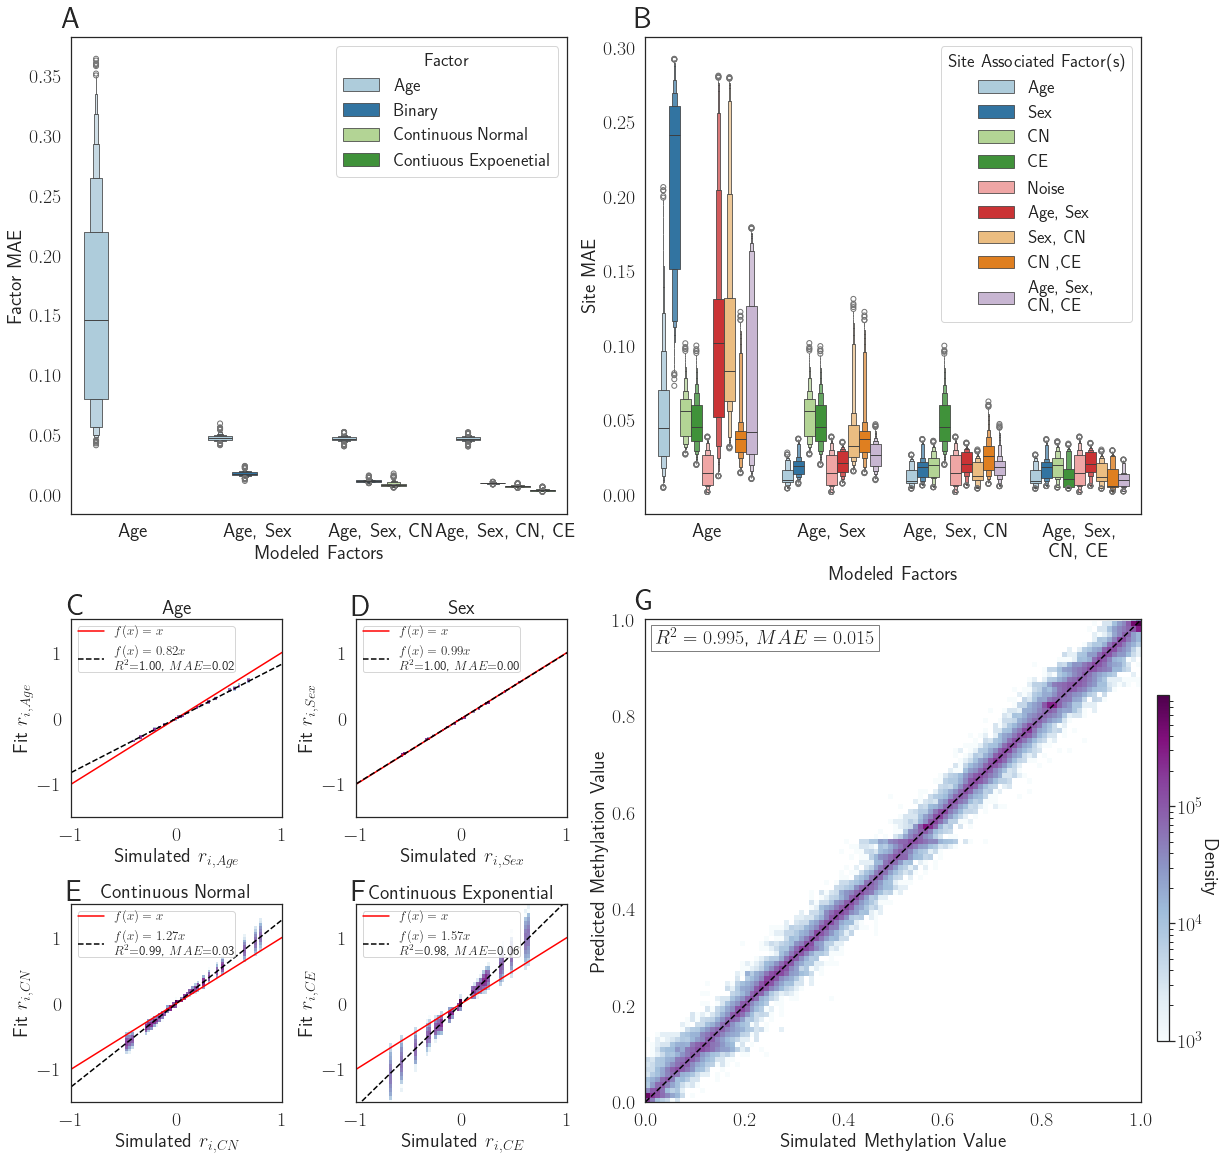

In [61]:
fig = plt.figure(constrained_layout=True, figsize=(8*2, 8*2))

gs = plt.GridSpec(4, 4, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:2])
sns.boxenplot(x='Factor Count', y='Factor MAE', hue='Factor', data=plot_df, ax=ax)
ax.set_xticklabels(['Age', 'Age, Sex', 'Age, Sex, CN', 'Age, Sex, CN, CE'])
ax.set_xlabel('Modeled Factors')
ax.text(-0.02, 1.02, 'A', fontsize=30, weight='bold', transform=ax.transAxes)

ax = fig.add_subplot(gs[0:2, 2:])
sns.boxenplot(x='Factor', y='Site MAE', hue='Site Associated Factor(s)', data=site_error_df, ax=ax)
ax.set_xticklabels(['Age', 'Age, Sex', 'Age, Sex, CN', 'Age, Sex,\nCN, CE'])
ax.set_xlabel('Modeled Factors')
ax.text(-0.02, 1.02, 'B', fontsize=30, weight='bold', transform=ax.transAxes)


model_labels = ['Age', 'Sex', 
                'Continuous Normal', 'Continuous Exponential']

fig_labels = ['C', 'D', 'E', 'F']

for count, pheno in enumerate(single_site_types):
    
    row, col = int(count/2), 0 if not count %2 else 1
    
    ax = fig.add_subplot(gs[row + 2, col])
    ax.text(-0.02, 1.02, fig_labels[count], fontsize=30, weight='bold', transform=ax.transAxes)

    
    _sim_coefs = site_coef_df.loc[site_coef_df['Sim. Factor'] == pheno]['Simulated Coefficient'].values
    _fit_coefs = site_coef_df.loc[site_coef_df['Sim. Factor'] == pheno]['Fit Coefficient'].values
    
    popt, pcov = optimize.curve_fit(lin_func, _sim_coefs, _fit_coefs)
    plot_exp = lin_func(np.linspace(-1,1,100), *popt)
    sign = '+' if popt[2] > 0 else ''
   
    mae = np.mean(abs(_sim_coefs - _fit_coefs))
    rsquared = stats.pearsonr(_sim_coefs, _fit_coefs)[0]**2
    plot_label = f'$f(x)={popt[0]:.2f}x$\n$R^{{2}}$={rsquared:.2f}, $MAE$={mae:.2f}'
    ax.plot([-1,1], [-1,1], 'r-', label='$f(x)=x$')
    ax.hist2d(x=_sim_coefs, y=_fit_coefs, bins=50, cmap=plt.cm.BuPu, norm=LogNorm(vmax=5000, vmin=1))
    ax.plot(np.linspace(-1,1,100), plot_exp, 'k--', label=plot_label)

    ax.legend(loc='upper left', fontsize=13, borderpad=0)
    
    ax.set_ylim([-1.5,1.5])
    ax.set_xlim([-1,1])
    ax.set_xlabel(f'Simulated $r_{{i,{pheno}}}$')
    ax.set_ylabel(f'Fit $r_{{i,{pheno}}}$')
    ax.set_title(model_labels[count], fontsize=20)
    
ax = fig.add_subplot(gs[2:, 2:])
ax.text(-0.02, 1.02, 'G', fontsize=30, weight='bold', transform=ax.transAxes)

model = meth_values[model_of_interest]
mr2 = stats.pearsonr(model['actual'], model['predicted'])[0]**2
mmae = np.mean(abs(model['actual'] - model['predicted']))
h = ax.hist2d(x=model['actual'], y=model['predicted'], 
              bins=100, cmap=plt.cm.BuPu, norm=LogNorm())
ax.plot([0,1], [0,1], 'k--')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_ylabel('Predicted Methylation Value')
ax.set_xlabel('Simulated Methylation Value')
ax.text(.02,.95,f'$R^2={mr2:.3f}$, $MAE={mmae:.3f}$', fontsize=20, transform=ax.transAxes, 
        bbox=dict(facecolor='none', edgecolor='grey'))

cbaxes = fig.add_axes([1.001, 0.1, 0.01, 0.3])  
cbar = fig.colorbar(h[3], cax=cbaxes)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(f'Density', rotation=270)

plt.savefig(os.path.join(wd, 'Paper/Figures/Figure2.png'), dpi=200, bbox_inches='tight')

In [62]:
cleaned_sim_states = {label: np.zeros((states[0].shape[0] * len(states), 
                                       states[0].shape[1])) for label, states in sim_states.items()}

cleaned_sim_exposures = {label: np.zeros((exposures[0].shape[0] * len(exposures), 
                                          exposures[0].shape[1])) for label, exposures in sim_exposures.items()}

for model_type in cleaned_sim_states:
    states = sim_states[model_type]
    exposures = sim_exposures[model_type]
    step_size = states[0].shape[0]
    for count in range(len(states)):
        cleaned_sim_states[model_type][count*step_size: count*step_size + step_size, :] = states[count]
        cleaned_sim_exposures[model_type][count*step_size: count*step_size + step_size, :] = exposures[count]

/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_37381/1292311565.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  t_ax.set_xticklabels([0, 1])
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_37381/1292311565.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  t_ax.set_xticklabels([0, 1])
/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covaria

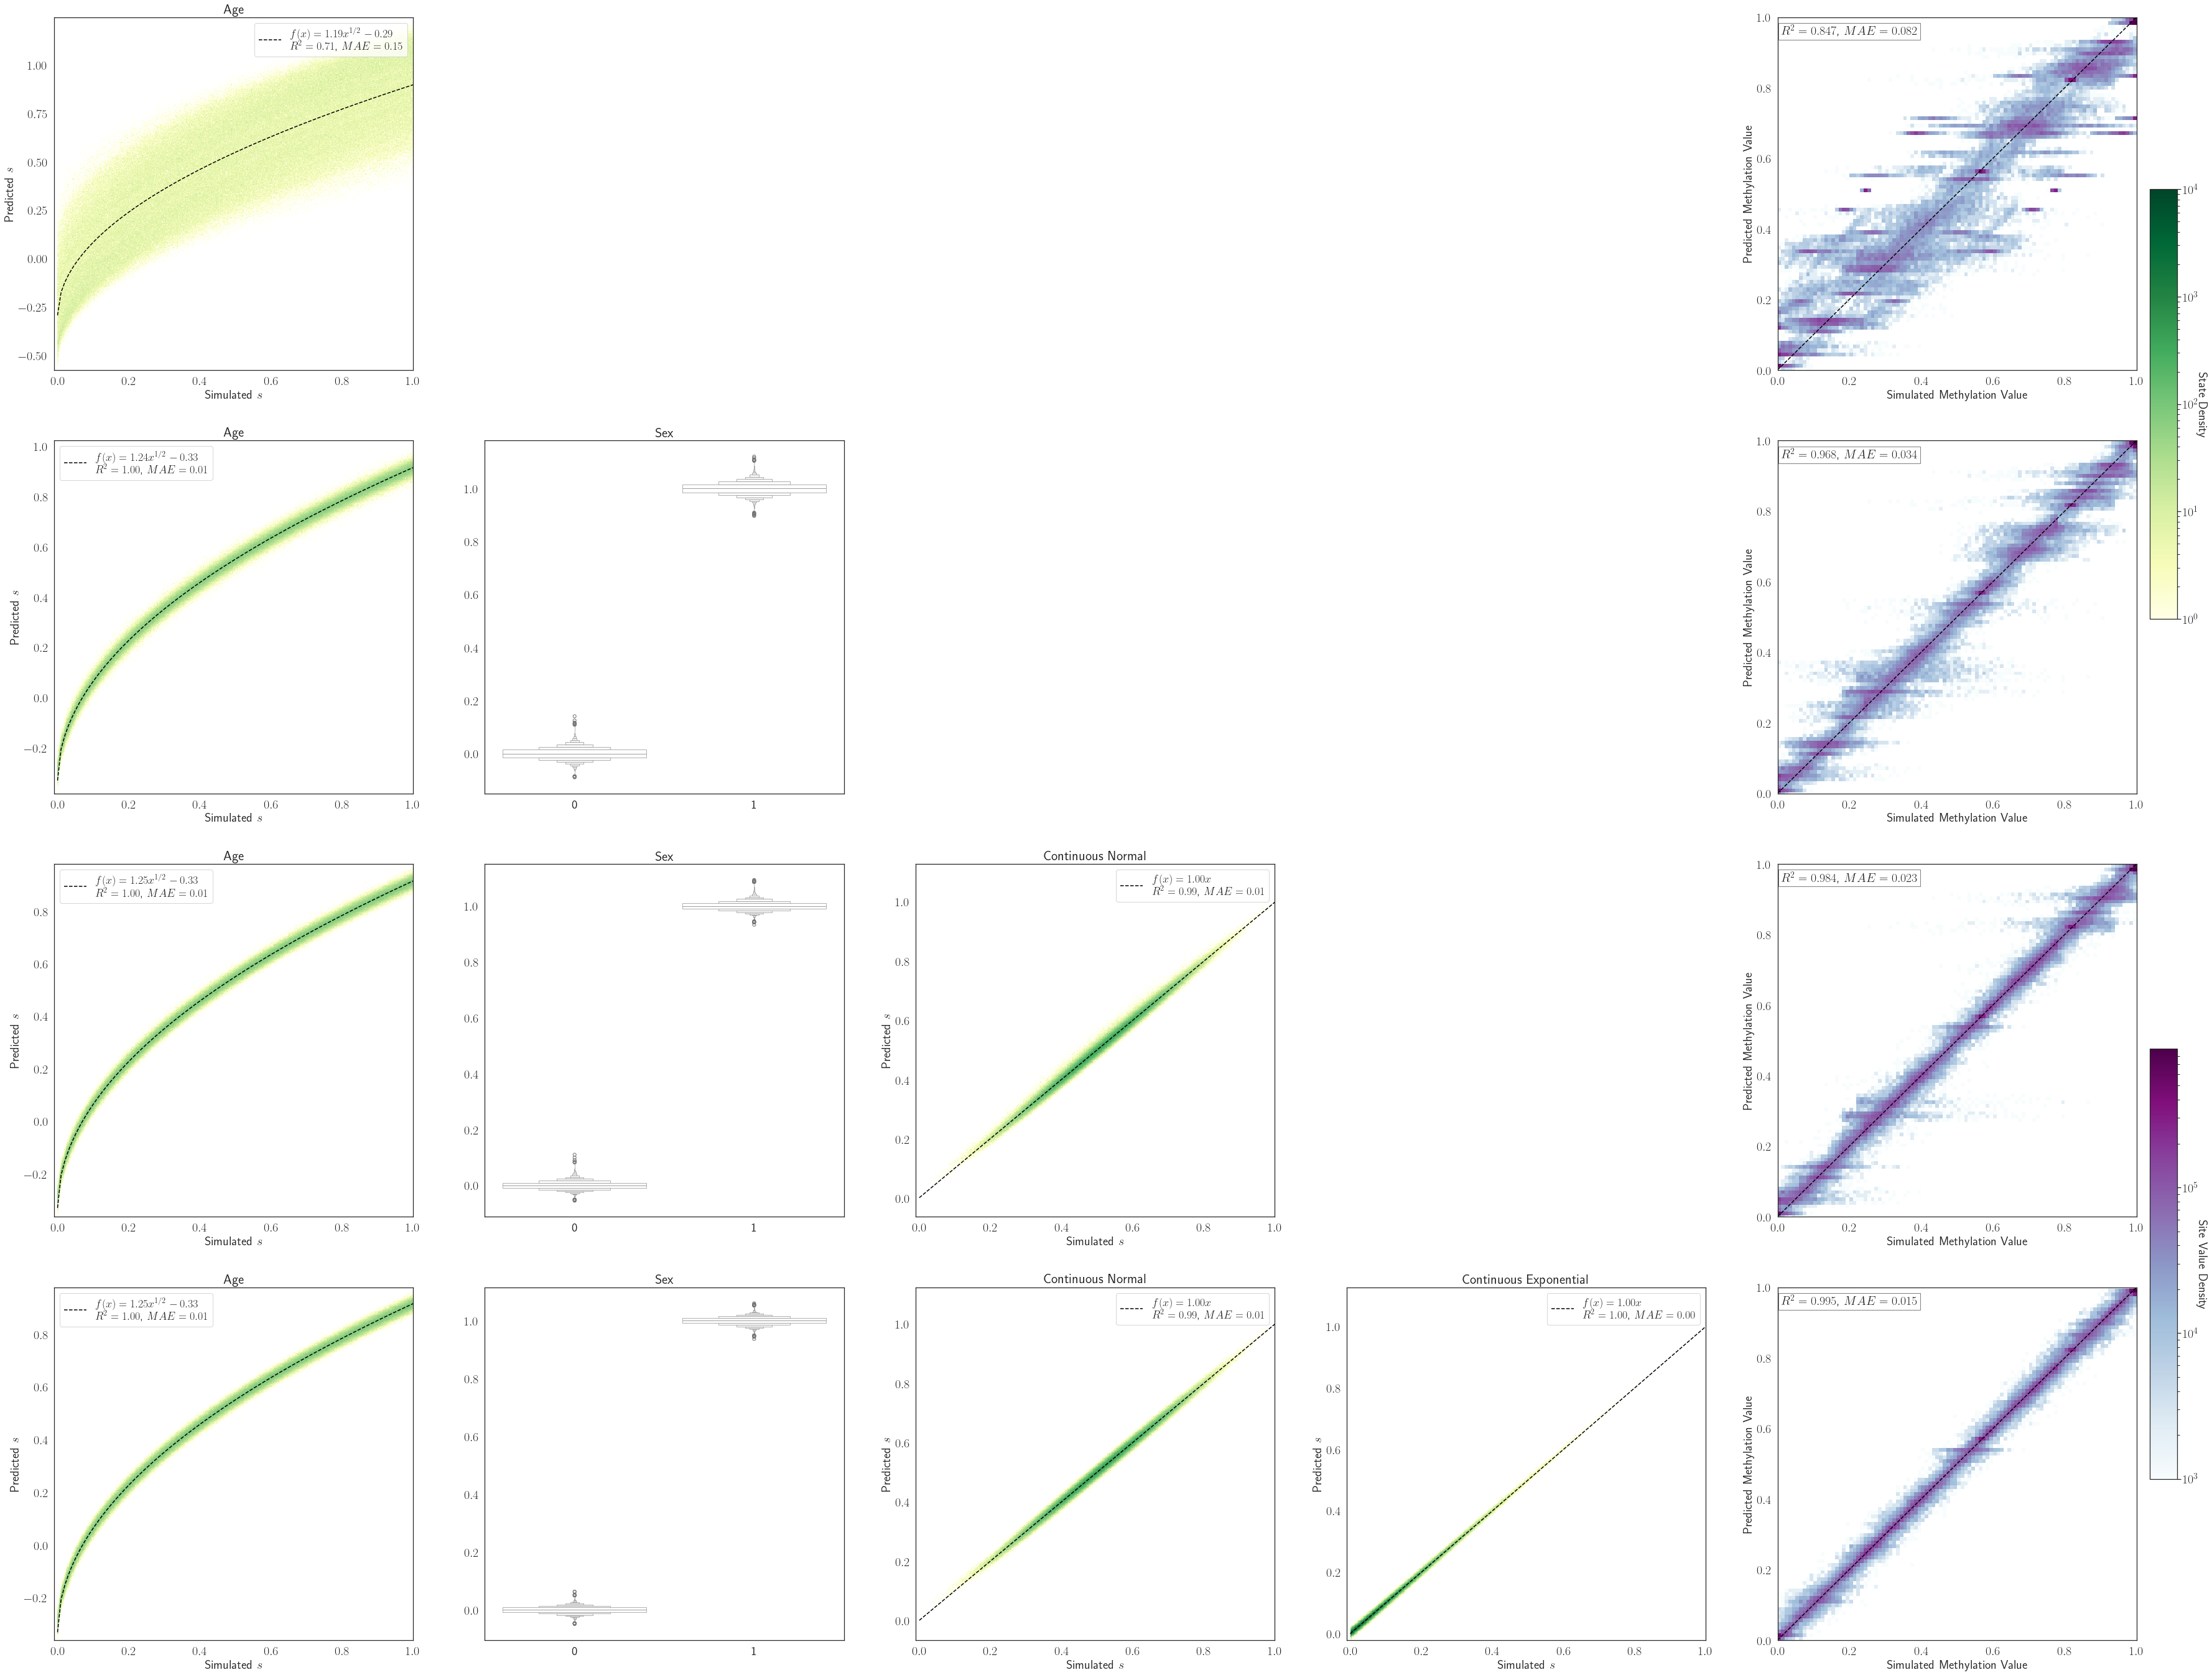

In [63]:
model_labels = ['Age', 'Sex', 'Continuous Normal', 'Continuous Exponential']

fig, ax = plt.subplots(len(cleaned_sim_states), 5, figsize=(12 * 5, 12 * 4))

for m_count, model in enumerate(cleaned_sim_states):
    states = cleaned_sim_states[model]
    exposures = cleaned_sim_exposures[model]
    for count in range(states.shape[1]):
        t_ax = ax[m_count, count]
        if count == 1:
            sns.boxenplot(x=exposures[:,count], y=states[:, count], ax=t_ax, color='white')
            t_ax.set_xticklabels([0, 1])
        else:
            exp, st = exposures[:, count], states[:, count]
            exponent = ''
            if count == 0:
                popt, pcov = optimize.curve_fit(sqrt_func, exp, st)
                expected = sqrt_func(exp, *popt)
                plot_exp = sqrt_func(np.linspace(0,1,100), *popt)
                exponent = '^{{1/2}}'
            else:
                popt, pcov = optimize.curve_fit(lin_func, exp, st)
                plot_exp = lin_func(np.linspace(0,1,100), *popt)
                expected = lin_func(exp, *popt)
            sign = '+' if popt[2] > 0 else ''
            mae = np.mean(abs(expected - st))
            rsquared = stats.pearsonr(expected, st)[0]**2
            if count == 0:
                plot_label = f'$f(x)={popt[0]:.2f}x{exponent}{sign}{popt[2]:.2f}$\n$R^{{2}}={rsquared:.2f}$, $MAE={mae:.2f}$'
            else:
                plot_label = f'$f(x)={popt[0]:.2f}x$\n$R^{{2}}={rsquared:.2f}$, $MAE={mae:.2f}$'
            t_ax.plot(np.linspace(0,1,100), plot_exp, 'k--', label=plot_label)
            h = t_ax.hist2d(x=exp, y=st, bins=500, 
                            cmap=plt.cm.YlGn, norm=LogNorm(vmin=1, vmax=10000))
            if m_count == 0 and count == 0:
                cbaxes = fig.add_axes([.905, 0.6, 0.01, 0.2])  
                cbar = fig.colorbar(h[3], cax=cbaxes)
                cbar.ax.get_yaxis().labelpad = 15
                cbar.ax.set_ylabel(f'State Density', rotation=270)
            t_ax.legend()
            t_ax.set_xlabel('Simulated $s$')
            t_ax.set_ylabel('Predicted $s$')
            t_ax.set_xlim([-.01,1])
        t_ax.set_title(model_labels[count], fontsize=22)
        
for count, model in enumerate(meth_values.values()):
    mr2 = stats.pearsonr(model['actual'], model['predicted'])[0]**2
    mmae = np.mean(abs(model['actual'] - model['predicted']))
    h = ax[count, 4].hist2d(x=model['actual'], y=model['predicted'], 
                        bins=100, cmap=plt.cm.BuPu, norm=LogNorm())
    ax[count, 4].plot([0,1], [0,1], 'k--')
    ax[count, 4].set_ylim([0,1])
    ax[count, 4].set_xlim([0,1])
    ax[count, 4].set_ylabel('Predicted Methylation Value')
    ax[count, 4].set_xlabel('Simulated Methylation Value')
    ax[count, 4].text(.01,.95,f'$R^2={mr2:.3f}$, $MAE={mmae:.3f}$', fontsize=20, transform=ax[count, 4].transAxes,
                      bbox=dict(facecolor='none', edgecolor='grey'))
    if count == 3:
        cbaxes = fig.add_axes([.905, 0.2, 0.01, 0.2])  
        cbar = fig.colorbar(h[3], cax=cbaxes)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel(f'Site Value Density', rotation=270)
        
        
for count in range(3):
    for empty_plot in range(3-count):
        ax[count, 3 - empty_plot].axis('off')

        
plt.savefig(os.path.join(wd, 'Paper/Figures/SupplementalFigure3.png'), dpi=200, bbox_inches='tight')
plt.show()

## Evaluate Effect of Varrying Number of Training Samples

In [64]:
def fit_varried_sample_number(fit_phenotypes: List[str] = None, phenotype_std_dist=0.1, 
                       sample_kwargs = None, site_conditions=None, meth_generator=None,
                       train_proportions=np.linspace(0.01,1,10), site_proportions=np.linspace(0.05, 1, 10),
                       verbose=0, n_jobs=8, q_scaler=None, p_scaler=None):
    
    # generate phenotype info 
    pheno = gen_phenotypes(phenotype_std_dist)
    samples = gen_samples(phenotypes=pheno)
    
    meth_matrix, meth_error = gen_meth_matrices(meth_generator, samples, site_conditions)
    
    q_matrix = gen_pheno_matrix(samples, fit_phenotypes, key='exposure')
    p_matrix = gen_pheno_matrix(samples, fit_phenotypes, key='value')
    
    scaled_q = q_scaler.transform(q_matrix)
    scaled_p = p_scaler.transform(p_matrix)
    
    train_indices = np.random.choice([x for x in range(len(samples))], size=int(len(samples) * 0.5), 
                                     replace=False)
    test_indices = np.array([x for x in range(len(samples)) if x not in train_indices])
    
    # retrieve and scale phenotypes 
    runs = []
    models = {}
    for prop in train_proportions:
        fit_len = int(len(train_indices) * prop)
        fit_indices, _ = train_test_split(train_indices, train_size=fit_len, stratify=scaled_q[train_indices,1])
        train_phenos = scaled_q[fit_indices,:]
        for site_prop in site_proportions:
            run_label = str(f'{prop:.3f}_{fit_len}_{site_prop:.3f}')
            fit_site_len = int(meth_matrix.shape[0] * site_prop)
            fit_site_indices = np.random.choice(np.arange(meth_matrix.shape[0]), 
                                                          size=fit_site_len, replace=False)
            fit_matrix = meth_matrix[fit_site_indices, :]
            models[run_label] = {'test_phenotypes':scaled_p[test_indices,:], 'fit_len': fit_len, 'fit_prop':prop,
                                 'test_exposures':scaled_q[test_indices,:], 'fit_site_indices':fit_site_indices,
                                 'site_prop': site_prop, 'fit_site_len':fit_site_len}
            runs.append([scaled_q[fit_indices,:], fit_matrix[:,fit_indices], fit_matrix[:,test_indices], run_label])
    model_runs = run_simulations(runs, n_jobs=n_jobs, verbose=verbose)
    for label, results in model_runs.items():
        models[label].update(results)
    return models

In [65]:
def assess_varried_train_model(model):
    trans_phenos = model['test_phenotypes']
    r2 = pearson_correlation(trans_phenos, model['states'].T)
    r2 = [r2[x][x]**2 for x in range(r2.shape[0])]
    mae = np.mean(abs(trans_phenos - model['states']), axis=0)
    coefs = model['msepm']._coefs
    error = model['msepm']._error
    site_error = np.mean(abs(model['test_predicted_meth'] - model['test_meth_values']), axis=1)
    return dict(r2=r2, mae=mae, coefs=coefs, model_error=error, mean_site_error=site_error,
                prop=model['fit_prop'], fit_len=model['fit_len'], site_prop=model['site_prop'],
                fit_site_len=model['fit_site_len'], fit_site_indices=model['fit_site_indices'])

In [66]:
prop_results = {}


for run in tqdm(range(1000)):
    iter_models = fit_varried_sample_number(['age', 'binary_only', 'continuous_no_age', 'continuous_no_age_exp'], phenotype_std_dist=0.05,
                                      sample_kwargs=sample_kwargs, site_conditions=conditions,
                                      meth_generator=meth_gen, n_jobs=8,
                                     train_proportions=np.linspace(0.01,.1,10), site_proportions=np.linspace(0.2, 1, 10), 
                                            q_scaler=q_scaler, p_scaler=p_scaler)
    prop_results[run] = {label: assess_varried_train_model(model) for label, model in iter_models.items()}
    for label in prop_results[run]:
        prop_results[run][label]['msepm'] = iter_models[label]['msepm']

100%|█████████████████████████████████████████████████| 1000/1000 [03:26<00:00,  4.84it/s]


In [67]:
prop_plot = []

plot_cats = ['r2', 'mae', 'mean_site_error', 'prop', 'fit_len']

run_count = 0

for cat, res in prop_results.items():
    for prop, prop_res in res.items():
        for count, pheno in enumerate(['Age', 'Sex', 'CN', 'CE']):
            prop_plot.append([prop_res['r2'][count], prop_res['mae'][count], prop_res['prop'], 
                              prop_res['fit_len'], prop_res['site_prop'], prop_res['fit_site_len'],
                              pheno, run_count])
    run_count += 1
    
prop_df = pd.DataFrame(prop_plot, columns=['R2', 'Factor MAE', 'Proportion Train', 'Training Samples', 
                                           'Site Proportion', 'Training Sites', 'Factor', 'Run Number'])

In [68]:
site_error_prop_plot = []

run_count = 0

for cat, res in prop_results.items():
    for prop, prop_res in res.items():
        for count, site in enumerate(prop_res['mean_site_error']):  
            site_error_prop_plot.append([prop_res['prop'], prop_res['fit_len'], 
                                         prop_res['site_prop'], prop_res['fit_site_len'],
                                         site, site_labels[prop_res['fit_site_indices'][count]], run_count])
    run_count += 1

site_prop_error_df = pd.DataFrame(site_error_prop_plot, columns=['Proportion', 'Training Samples', 
                                                                 'Site Proportion', 'Training Sites',
                                                                 'Site MAE', 'Site Associated Factor(s)', 'Run Count'])

/home/colin/.pyenv/versions/3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


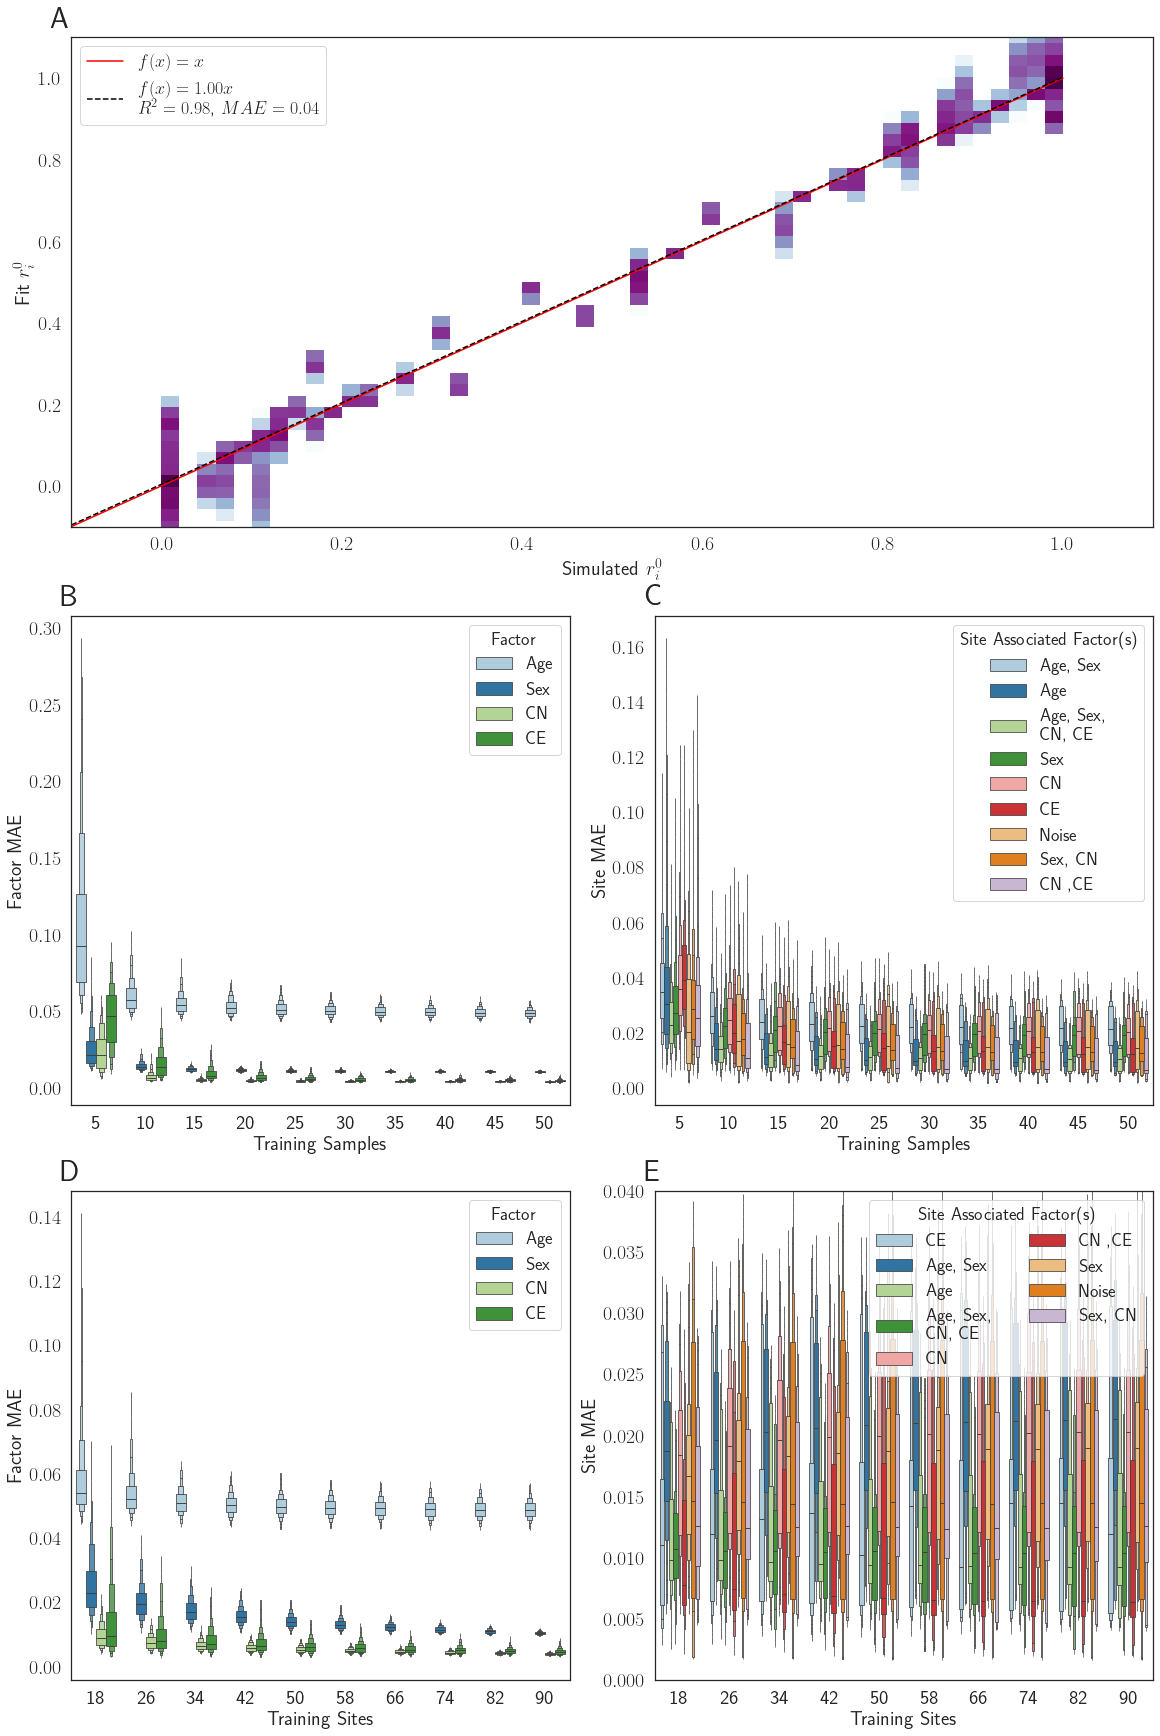

In [69]:
fig = plt.figure(constrained_layout=True, figsize=(8*2, 8*3))

gs = plt.GridSpec(6, 4, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:4])
_fit_inter, _sim_inter = _site_inters[:,0], _site_inters[:,1]
popt, pcov = optimize.curve_fit(lin_func, _sim_inter, _fit_inter)
plot_exp = lin_func(np.linspace(-1,1,100), *popt)
sign = '+' if popt[2] > 0 else ''
mae = np.mean(abs(_sim_inter - _fit_inter))
rsquared = stats.pearsonr(_sim_inter, _fit_inter)[0]**2
plot_label = f'$f(x)={popt[0]:.2f}x$\n$R^{{2}}={rsquared:.2f}$, $MAE={mae:.2f}$'
ax.plot([-1,1], [-1,1], 'r-', label='$f(x)=x$')
ax.hist2d(x=_sim_inter, y=_fit_inter, bins=50, cmap=plt.cm.BuPu, norm=LogNorm(vmax=5000, vmin=1))
ax.plot(np.linspace(-1,1,100), plot_exp, 'k--', label=plot_label)
ax.legend(loc='upper left')
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.1,1.1])
ax.set_xlabel(f'Simulated $r^0_{{i}}$')
ax.set_ylabel(f'Fit $r^0_{{i}}$')
ax.text(-0.02, 1.02, 'A', fontsize=30, weight='bold', transform=ax.transAxes)


ax = fig.add_subplot(gs[2:4, 0:2])
ax.text(-0.02, 1.02, 'B', fontsize=30, weight='bold', transform=ax.transAxes)

sns.boxenplot(x='Training Samples', y='Factor MAE', 
              data=prop_df.loc[prop_df['Site Proportion'] == 1.0],
              hue='Factor',
              ax=ax,
              showfliers=False)

ax = fig.add_subplot(gs[2:4, 2:])
ax.text(-0.02, 1.02, 'C', fontsize=30, weight='bold', transform=ax.transAxes)

sns.boxenplot(x='Training Samples', y='Site MAE', 
              data=site_prop_error_df.loc[site_prop_error_df['Site Proportion'] == 1.0],
              hue='Site Associated Factor(s)',
              showfliers=False)

ax = fig.add_subplot(gs[4:, 0:2])
ax.text(-0.02, 1.02, 'D', fontsize=30, weight='bold', transform=ax.transAxes)

sns.boxenplot(x='Training Sites', y='Factor MAE', 
              data=prop_df.loc[prop_df['Training Samples'] == 50],
              hue='Factor',
              ax=ax,
              showfliers=False)

ax = fig.add_subplot(gs[4:, 2:])
ax.text(-0.02, 1.02, 'E', fontsize=30, weight='bold', transform=ax.transAxes)

sns.boxenplot(x='Training Sites', y='Site MAE', 
              data=site_prop_error_df.loc[site_prop_error_df['Training Samples'] == 50],
              hue='Site Associated Factor(s)',
              showfliers=False)
ax.set_ylim(0.00, 0.04)
plt.legend(title='Site Associated Factor(s)', ncol=2)

plt.savefig(os.path.join(wd,'Paper/Figures/SupplementalFigure1.png'), dpi=200, bbox_inches='tight')

plt.show()